### Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

### Selected Labels of Abnormalities

In [2]:
selected_labels = ['pneumothorax', 'cardiomegaly', 'nodule', 'mass', 'effusion', 'atelectasis', 'consolidation', 'infiltration']

### Import Dataset

In [3]:
meta_data_df = pd.read_csv("NIH Chest X-rays (metadata).csv")
meta_data_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN


### The Actual Labels from Dataset


In [4]:
# Extracting and parsing the unique labels from the 'Finding Labels' column
# We will split by the '|' delimiter and then count the occurrence of each unique label

# Splitting labels into a list
labels_series = meta_data_df['Finding Labels'].str.split('|').explode().reset_index(drop=True)

# Counting each unique label
label_counts = labels_series.value_counts().reset_index()
label_counts.columns = ['Label', 'Count']

label_counts

,Label,Count
0,No Finding,60361
1,Infiltration,19894
2,Effusion,13317
3,Atelectasis,11559
4,Nodule,6331
5,Mass,5782
6,Pneumothorax,5302
7,Consolidation,4667
8,Pleural_Thickening,3385
9,Cardiomegaly,2776


### Average age on the dataset

In [5]:
# Calculate data distribution for the "Patient Age" column
age_distribution = {
    "Mean Age": meta_data_df["Patient Age"].mean(),
    "Minimum Age": meta_data_df["Patient Age"].min(),
    "Maximum Age": meta_data_df["Patient Age"].max()
}

age_distribution

{'Mean Age': 46.90146271851587, 'Minimum Age': 1, 'Maximum Age': 414}

### Check Outliers of Age Values

Outliers based on Z-score:
        Patient Age  Age Z-score
20852           412    21.680632
46965           414    21.799398
48284           148     6.003530
55742           148     6.003530
58650           150     6.122296
62929           149     6.062913
74884           152     6.241062
78795           151     6.181679
84810           411    21.621249
85404           412    21.680632
86264           413    21.740015
91369           412    21.680632
95794           153     6.300445
98495           154     6.359828
101194          155     6.419211
104590          155     6.419211


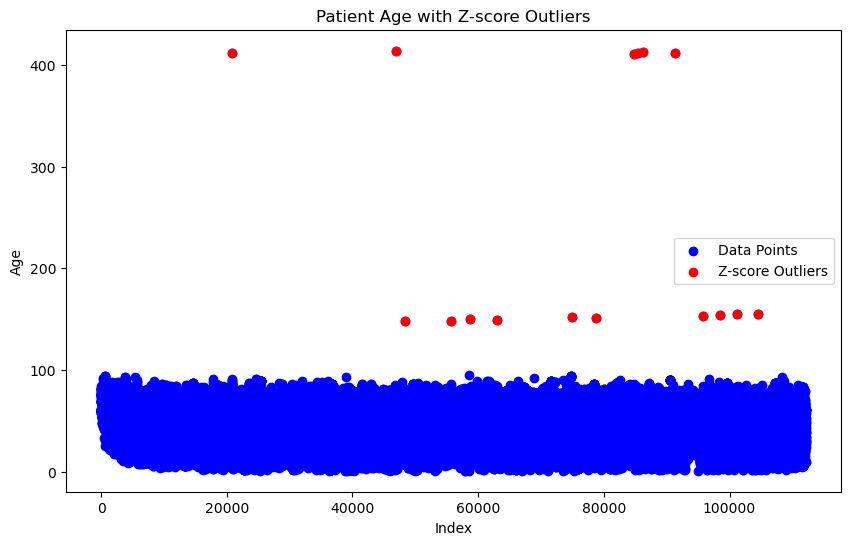

In [6]:
# Assuming 'df' is your DataFrame and 'Patient Age' is the column to check
meta_data_df['Age Z-score'] = zscore(meta_data_df['Patient Age'])

# Filter rows with absolute Z-score greater than 3 (outliers)
outliers_zscore = meta_data_df[abs(meta_data_df['Age Z-score']) > 3]
print("Outliers based on Z-score:")
print(outliers_zscore[['Patient Age', 'Age Z-score']])

# Scatter plot of age with Z-score outliers highlighted
plt.figure(figsize=(10, 6))
plt.scatter(meta_data_df.index, meta_data_df['Patient Age'], label='Data Points', color='blue')
plt.scatter(outliers_zscore.index, outliers_zscore['Patient Age'], color='red', label='Z-score Outliers')
plt.title("Patient Age with Z-score Outliers")
plt.xlabel("Index")
plt.ylabel("Age")
plt.legend()
plt.show()

### Delete some rows containing outliers on age values, because I wanna make my dataset confident

In [7]:
from scipy.stats import zscore

# Calculate Z-scores for the 'Patient Age' column
meta_data_df['Age Z-score'] = zscore(meta_data_df['Patient Age'])

# Filter out rows with Z-score greater than 3 or less than -3 (outliers)
meta_data_df_no_outliers_zscore = meta_data_df[abs(meta_data_df['Age Z-score']) <= 3].drop(columns=['Age Z-score'])

print("Data without Z-score outliers:")
meta_data_df_no_outliers_zscore


Data without Z-score outliers:


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN


### Acquaire only 500 images per labels

In [8]:
# Initialize a new dataframe to collect the filtered results
filtered_df = pd.DataFrame()

# Go through each label and select 500 images, ensuring not to reuse previously selected images
remaining_df = meta_data_df.copy()

for label in selected_labels:
    num_images_per_labels = 1000
    # Select rows containing the current label in the 'Finding Labels' column
    label_df = remaining_df[remaining_df['Finding Labels'].str.contains(label, case=False, na=False)]
    
    # Select up to 500 entries for this label
    # exeption for nodul/mass, it will be taken only 250 each
    if label == 'nodule' or label == 'mass':
        selected_label_df = label_df.head(int(num_images_per_labels/2))
    else:
        selected_label_df = label_df.head(num_images_per_labels)
        
    # Append the selected rows to the filtered dataframe
    filtered_df = pd.concat([filtered_df, selected_label_df], ignore_index=True)
    
    # Remove these selected rows from the remaining dataframe
    remaining_df = remaining_df.drop(selected_label_df.index)
filtered_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Age Z-score
0,00000013_001.png,Emphysema|Pneumothorax,1,13,60,M,AP,3056,2544,0.139,0.139,NaN,0.777830
1,00000013_002.png,Emphysema|Pneumothorax,2,13,60,M,AP,3056,2544,0.139,0.139,NaN,0.777830
2,00000013_004.png,Effusion|Emphysema|Infiltration|Pneumothorax,4,13,60,M,AP,3056,2544,0.139,0.139,NaN,0.777830
3,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,60,M,AP,3056,2544,0.139,0.139,NaN,0.777830
4,00000013_010.png,Effusion|Pneumonia|Pneumothorax,10,13,60,M,AP,3056,2544,0.139,0.139,NaN,0.777830
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,00002888_001.png,Infiltration,1,2888,43,F,PA,2992,2991,0.143,0.143,NaN,-0.231680
6996,00002892_003.png,Infiltration,3,2892,49,F,AP,2500,2048,0.171,0.171,NaN,0.124617
6997,00002892_005.png,Infiltration,5,2892,49,F,AP,2500,2048,0.171,0.171,NaN,0.124617
6998,00002894_000.png,Infiltration,0,2894,57,F,PA,2536,2868,0.139,0.139,NaN,0.599681


### Reconstruct the 'Finding Labels' value only selected labels

In [9]:
# Function to filter findings to only include selected labels
def filter_labels(label_string):
    # Split the label string into individual labels
    labels = label_string.lower().split('|')
    # Keep only those labels that are in the selected_labels list
    filtered_labels = [label for label in labels if label in selected_labels]
    # Join the filtered labels back into a single string
    return '|'.join(filtered_labels) if filtered_labels else None

# Apply the function to filter labels in the "Finding Labels" column
filtered_df = filtered_df.copy()
filtered_df['Finding Labels'] = filtered_df['Finding Labels'].apply(filter_labels)
filtered_df


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Age Z-score
0,00000013_001.png,pneumothorax,1,13,60,M,AP,3056,2544,0.139,0.139,NaN,0.777830
1,00000013_002.png,pneumothorax,2,13,60,M,AP,3056,2544,0.139,0.139,NaN,0.777830
2,00000013_004.png,effusion|infiltration|pneumothorax,4,13,60,M,AP,3056,2544,0.139,0.139,NaN,0.777830
3,00000013_005.png,infiltration|pneumothorax,5,13,60,M,AP,3056,2544,0.139,0.139,NaN,0.777830
4,00000013_010.png,effusion|pneumothorax,10,13,60,M,AP,3056,2544,0.139,0.139,NaN,0.777830
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,00002888_001.png,infiltration,1,2888,43,F,PA,2992,2991,0.143,0.143,NaN,-0.231680
6996,00002892_003.png,infiltration,3,2892,49,F,AP,2500,2048,0.171,0.171,NaN,0.124617
6997,00002892_005.png,infiltration,5,2892,49,F,AP,2500,2048,0.171,0.171,NaN,0.124617
6998,00002894_000.png,infiltration,0,2894,57,F,PA,2536,2868,0.139,0.139,NaN,0.599681


In [10]:
# Extracting and parsing the unique labels from the 'Finding Labels' column
# We will split by the '|' delimiter and then count the occurrence of each unique label

# Splitting labels into a list
labels_series = filtered_df['Finding Labels'].str.split('|').explode().reset_index(drop=True)

# Counting each unique label
label_counts = labels_series.value_counts().reset_index()
label_counts.columns = ['Label', 'Count']
label_counts

,Label,Count
0,infiltration,2378
1,effusion,1730
2,atelectasis,1709
3,consolidation,1364
4,pneumothorax,1017
5,cardiomegaly,1015
6,nodule,695
7,mass,672


### Normalization Dataset to Multi-hot Encoding

In [11]:
# Convert labels to lowercase for case-insensitive matching
filtered_df['Finding Labels'] = filtered_df['Finding Labels'].str.lower()

# Filter rows that contain any of the selected labels
normalized_filtered_df = filtered_df[filtered_df['Finding Labels'].str.contains('|'.join(selected_labels))]

# Keep only the 'Image Index' and 'Finding Labels' columns
normalized_filtered_df = normalized_filtered_df[['Image Index', 'Finding Labels']]

# Creating multi-hot encoding by spreading the labels
# First, split the labels for multi-label cases, then use get_dummies to encode them
normalized_filtered_df = normalized_filtered_df.join(normalized_filtered_df['Finding Labels'].str.get_dummies(sep='|'))

# Dropping the 'Finding Labels' column since it's now encoded
normalized_filtered_df = normalized_filtered_df.drop(columns=['Finding Labels'])
normalized_filtered_df

,Image Index,atelectasis,cardiomegaly,consolidation,effusion,infiltration,mass,nodule,pneumothorax
0,00000013_001.png,0,0,0,0,0,0,0,1
1,00000013_002.png,0,0,0,0,0,0,0,1
2,00000013_004.png,0,0,0,1,1,0,0,1
3,00000013_005.png,0,0,0,0,1,0,0,1
4,00000013_010.png,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...
6995,00002888_001.png,0,0,0,0,1,0,0,0
6996,00002892_003.png,0,0,0,0,1,0,0,0
6997,00002892_005.png,0,0,0,0,1,0,0,0
6998,00002894_000.png,0,0,0,0,1,0,0,0


### Combine Nodule and Mass column into 1 column 'Nodule/Mass'

In [12]:
# Combine 'mass' and 'nodule' columns into 'nodule/mass' using the OR operator
normalized_filtered_df['nodule/mass'] = normalized_filtered_df[['mass', 'nodule']].max(axis=1)

# Drop the original 'mass' and 'nodule' columns
normalized_filtered_df = normalized_filtered_df.drop(columns=['mass', 'nodule'])
normalized_filtered_df.to_csv("image_index_selected_labels (1000_per_label).csv")
normalized_filtered_df

,Image Index,atelectasis,cardiomegaly,consolidation,effusion,infiltration,pneumothorax,nodule/mass
0,00000013_001.png,0,0,0,0,0,1,0
1,00000013_002.png,0,0,0,0,0,1,0
2,00000013_004.png,0,0,0,1,1,1,0
3,00000013_005.png,0,0,0,0,1,1,0
4,00000013_010.png,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...
6995,00002888_001.png,0,0,0,0,1,0,0
6996,00002892_003.png,0,0,0,0,1,0,0
6997,00002892_005.png,0,0,0,0,1,0,0
6998,00002894_000.png,0,0,0,0,1,0,0


### Split Dataset for Testing and K-fold Validation

In [13]:
# Shuffle the dataset first
shuffled_df = normalized_filtered_df.sample(frac=1).reset_index(drop=True)

# Step 1: Split the dataset into 80% training and 20% test sets
train_data, test_data = train_test_split(shuffled_df, test_size=0.2, random_state=42)

# Step 2: Set up k-fold cross-validation on the training data with k=5
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initiate Excel File
excel_filename = "Split_NIH_ThoracicAbnotmalities_Dataset (1000/label).xlsx"
writer_excel = pd.ExcelWriter(excel_filename, engine='xlsxwriter')

# Splitting the training data into 5 folds and organizing them into DataFrames
for fold_i, (train_index, val_index) in enumerate(kf.split(train_data), 1):
    train_fold = train_data.iloc[train_index].reset_index(drop=True)
    val_fold = train_data.iloc[val_index].reset_index(drop=True)
    # Create Sheet Name of Train and Validation at per Fold
    sheet_train_name = "fold_{}_train".format(fold_i)
    sheet_val_name = "fold_{}_val".format(fold_i)
    # Save Dataframe each Sheet
    train_fold.to_excel(writer_excel, sheet_name=sheet_train_name)
    val_fold.to_excel(writer_excel, sheet_name=sheet_val_name)
    
# Saving test_data to sheet
test_data.to_excel(writer_excel, sheet_name="test")

# Save all works
writer_excel.close()

OSError: Cannot save file into a non-existent directory: 'Split_NIH_ThoracicAbnotmalities_Dataset (1000'